# GameSearch Video Game Recommender
Welcome to the GameSearch Video Game Recommendation app!  

Right now, this app functions inside of Jupyter entirely. To use it, you'll run each cell in order, following any instructions that show up!
Some cells may take longer than others to run -- if you see an asterisk inside of the square brackets to the left of a cell, that means it's still running, so just be patient!

You'll need access to some python libraries for the app to work properly, so lets go ahead and install them!  
*Note: if you already have one of these libraries installed, you shouldn't need to run the command. You can comment out the line by placing a '\#' at the start of it.*

***This app was designed in Jupyter Lab and may not function properly on Jupyter Lite. Please use either Jupyter Lab or Jupyter Notebook -- NON-LITE versions***

In [26]:
#%pip install pandas
#%pip install scikit-learn
#%pip install matplotlib
#%pip install seaborn
#%pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Connor\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


### Import Modules
Now that we have the correct libraries installed, we need to import the modules we're going to use. Go ahead and run this cell to import everything we'll need for the app!

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from ast import literal_eval
import utilities as util
from sklearn.metrics.pairwise import cosine_similarity
import operator
from tabulate import tabulate
from sklearn.preprocessing import minmax_scale, normalize
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

### Retrieve Data
This cell will read in our raw video game data from a csv file.

In [20]:
# Read in our data from the csv file
game_data = pd.read_csv("backloggd_games.csv",converters={"Developers": literal_eval, "Platforms": literal_eval, "Genres": literal_eval})

### Select a Game
Now for some input from you! When you run this cell, you will be asked to input the name of a game you want recommendations based off.  

Some notes:  
- You need to be specific about the game you want -- the search functionality is limited. If you want 'Dark Souls III', you can't type 'Dark Souls 3' -- you need to match the 'III'
- You do not need to type out the entire game, just try to do the most specific part to prevent accidently getting the wrong game. For example, I might search 'combat evo' if I want 'Halo: Combat Evolved'
- If you type a general name like 'Halo', you'll get the first Halo game that shows up in our data, so if you want 'Halo: Reach', you'll need to specifically type that.
- If the search functionality does **NOT** find your game, please re-run the cell and try again.
- The search functionality isn't case sensitive

In [21]:
# Have the user search for a game -- make sure to be specific, this is a very basic search function
user_search = input("Input the name of a video game you want recommendations based off: ")
try:
    selected_game = game_data[game_data['Title'].str.contains(user_search, case=False)].iloc[0].to_frame().T
    print('Selected Game: ', selected_game.Title.values[0])
except IndexError:
    print("Couldn't find that game. Please try again.")

Input the name of a video game you want recommendations based off:  Bloodborne


Selected Game:  Bloodborne


### Configure Search Options
Now, we'll customize how we find your recommendations. When you run this cell, you will be asked 6 questions, each relating to how we judge similarity to the game you selected. These choices can heavily impact your recommendations, so think about what you want from your recommendations and choose options accordingly.  

- If you really like the Developer of the game you chose, and would like to see other games made by them, choose 'y' on the first option.
- If you want to have a game that exists on similar platforms to the game you selected, choose 'y' on the second option. This means if your chosen game exists on Xbox 360 and Playstation 3, your recommendations will revolve closer to other games on those consoles.
- If you like the genres of your game, choose 'y' to the third option. This is the 'core' of a video game, so it's highly recommended to choose 'y' on this option. This will get you recommendations with more similar gameplay to your chosen game.
- If you prefer to be recommended games that have higher ratings, choose 'y' on the fourth option.
- If you prefer to be recommended games that have a high 'popularity' (based on other people playing them from this data), choose 'y' on the fifth option.
- If you want to **exclude** dlc/addons for your selected game, choose 'y' on the sixth option. This feature is imperfect, but will filter out games that match the title of your game. For example, If I chose 'Dark Souls III' and excluded dlc/addons, I wouldn't be recommened 'Dark Souls III: The Fire Fades Edition'

Lastly, please make sure to say 'y' to at least one option, otherwise the app will not work.

*Note: if you enter an incorrect input, a default option will be selected for you.*

In [22]:
# Configure options for the recommender
search_options = []
similarity_labels = []
# 1. Search by similar developers
dev = input('Do you want games with similar developers? (y/n): ')
if dev.lower() == 'y':
    search_options.append(1)
    similarity_labels.append('Developers')
elif dev.lower() == 'n':
    search_options.append(0)
else:
    print('Invalid input. Defaulting to false for developer option.')
    search_options.append(0)
# 2. Search by similar platforms
plat = input('Do you want games with similar platforms (xbox, pc, etc.)? (y/n): ')
if plat.lower() == 'y':
    search_options.append(1)
    similarity_labels.append('Platforms')
elif plat.lower() == 'n':
    search_options.append(0)
else:
    print('Invalid input. Defaulting to false for platform option.')
    search_options.append(0)
# 3. Search by similar genre **recommended**
gen = input('Do you want games with similar genres (recommended)? (y/n): ')
if gen.lower() == 'y':
    search_options.append(1)
    similarity_labels.append('Genres')
elif gen.lower() == 'n':
    search_options.append(0)
else:
    print('Invalid input. Defaulting to true for genre option.')
    search_options.append(1)
    similarity_labels.append('Genres')
# 4. Search by similar ratings
rat = input('Do you prefer games with high ratings? (y/n): ')
if rat.lower() == 'y':
    search_options.append(1)
    similarity_labels.append('Ratings')
elif rat.lower() == 'n':
    search_options.append(0)
else:
    print('Invalid input. Defaulting to false for rating option.')
    search_options.append(0)
# 5. Search by similar popularity
pop = input('Do you prefer games with high popularity? (y/n): ')
if pop.lower() == 'y':
    search_options.append(1)
    similarity_labels.append('Popularity')
elif pop.lower() == 'n':
    search_options.append(0)
else:
    print('Invalid input. Defaulting to false for popularity option.')
    search_options.append(0)
# 6. Ignore DLC/Addons for the selected game -- note that this is an imperfect feature, but it does work well as long as the selected game title is shorter than the DLC title, which is usually the case
dlc = input('Do you want to exclude dlc/addons for the game you selected? (y/n): ')
if dlc.lower() == 'y':
    search_options.append(1)
elif dlc.lower() == 'n':
    search_options.append(0)
else:
    print('Invalid input. Defaulting to false for dlc/addon option.')
    search_options.append(0)

Do you want games with similar developers? (y/n):  y
Do you want games with similar platforms (xbox, pc, etc.)? (y/n):  y
Do you want games with similar genres (recommended)? (y/n):  y
Do you prefer games with high ratings? (y/n):  y
Do you prefer games with high popularity? (y/n):  y
Do you want to exclude dlc/addons for the game you selected? (y/n):  y


### Generating and Normalizing Comparison Data

This is the 'prep' part of the app! Run the next 5 cells in order, they will generate and normalize data that will then be used to get similarity scores!

We have up to 5 categories that can be used to find similarity. Each cell corresponds to one category. They generate arrays of numbers between 0 and 1 for each type item in that category. For example, if we have 10 unique game genres, an array of 10 numbers will be generated for every game in the dataset. A 1 is inserted if that game has that genre, a 0 otherwise. Ratings and Popularity work a little differently. They take the number for each game and scale it to be between 0 and 1 based on all the data we have.

In [23]:
# There are too many unique developers to have a binary of them all for every game, so we'll only use the developers of the selected game
if search_options[0] == 1:
    uniqueDeveloperList = []
    for developer in selected_game['Developers'].values[0]:
        if developer not in uniqueDeveloperList:
            uniqueDeveloperList.append(developer)
    
    # Generate a binary value list of developers for each game
    game_data['Developers_Binary'] = game_data['Developers'].apply(lambda vals: util.generateBinaryVals(uniqueDeveloperList, vals))

In [24]:
# Get a list of unique platforms in our dataset
if search_options[1] == 1:
    uniquePlatformList = []
    for index, row in game_data.iterrows():
        platforms = row["Platforms"]
        
        for platform in platforms:
            if platform not in uniquePlatformList:
                uniquePlatformList.append(platform)
    
    # Generate a binary value list of platforms for each game
    game_data['Platforms_Binary'] = game_data['Platforms'].apply(lambda vals: util.generateBinaryVals(uniquePlatformList, vals))

In [25]:
# Get a list of unique genres in our dataset
if search_options[2] == 1:
    uniqueGenreList = []
    for index, row in game_data.iterrows():
        genres = row["Genres"]
        
        for genre in genres:
            if genre not in uniqueGenreList:
                uniqueGenreList.append(genre)
    
    # Generate a binary value list of genres for each game
    game_data['Genres_Binary'] = game_data['Genres'].apply(lambda vals: util.generateBinaryVals(uniqueGenreList, vals))

In [26]:
# Scale the ratings
ratings_scaled = minmax_scale(game_data['Rating'].values)
game_data['Rating_Scaled'] = ratings_scaled

In [27]:
# Scale the popularity (plays)
plays_scaled = minmax_scale(game_data['Plays'].values)
game_data['Plays_Scaled'] = plays_scaled

### Calculate Similarity

Here's the machine learning part of the app! For every single game in the dataset, we pass in your selected game and a game from the data. For each category you selected earlier, a 'similarity score' is generated. For the first three categories (developers, platforms, and genres), this score is generated based on the 'cosine similarity' algorithm. This algorithm finds the consine of the angle between our two sets of data. The closer together an angle is, the closer to 1 the cosine of that angle will be. So, if the genres of two games have a cosine similarity of 0.86, they're pretty close to each other.

Ratings and Popularity have already been scaled to between 0 and 1, so cosine similarity isn't needed for those two categories.

Finally, with a similarity score generated for each category, we take the average of all the scores, giving us a final similarity score. This score represents how close of a match each game is with your selected game. These final scores are stored in an array, and then sorted by descending. This array now represents the 'nearest neighbors' to your game!

In [28]:
# Grab an updated version of the selected game that includes the binaries
selected_game = game_data.iloc[selected_game['Id']]

# Calculate the similarity of each game in our data to the user-selected game
similarity_scores = []
all_scores = []

for index, game in game_data.iterrows():
    if search_options[5] == 1: # ignore dlc/addons for the same game
        if selected_game['Title'].values[0].lower() not in game['Title'].lower():
            scores = util.generateSimilarityScore(selected_game, game, search_options)
            sim_score = np.mean(scores).item() # average the scores
            similarity_scores.append((game['Id'], sim_score))
            all_scores.append(scores)
        # The heatmap needs every game to have similarity scores, so set full 0's for game dlc/addons if we're ignoring them
        else:
            scores = []
            for i in range(len(similarity_labels)):
                scores.append(0)
            all_scores.append(scores)
    else:
        scores = util.generateSimilarityScore(selected_game, game, search_options)
        sim_score = np.mean(scores).item() # average the scores
        similarity_scores.append((game['Id'], sim_score))
        all_scores.append(scores)


game_data['Similarity_Scores'] = all_scores
similarity_scores.sort(key=operator.itemgetter(1), reverse=True)

### 'K' Nearest Neighbors

We'll need your input one more time before we're done. The other machine learning algorithm in use is called K Nearest Neighbors. The idea is simply to find the nearest 'neighbors' to our given data point (your selected game). We already used cosine similarity to generate the list of neighbors and their 'locations', but now you get to decide the 'K' -- that is, how many neighbors do you want? This really just translates to how many game recommendations to you want to see, whether it be the top 5, or 10, etc.

*Note: if you enter anything besides an integer, you'll be asked to try again. Run the cell block again, and enter just an integer*

In [29]:
# Get the desired amount of neighbors
K = input('How many recommendations do you want? ')
try:
    K = literal_eval(K)
    if type(K) is not int:
        raise ValueError
except(ValueError, SyntaxError):
    print('You did not enter an integer. Please try again.')

How many recommendations do you want?  3


### Your Results!!!

You've made it this far, are you ready to see your recommendations? Go ahead and run the next cell block. This cell will go through the nearest neighbor list and get the data for your K nearest neighbors, or best recommendations. Then, that data will be tabulated by a handy library so that it can be displayed to you in a pretty visual grid!

In [30]:
# Get the K nearest neighbors
neighbors = []
index_list = []
for i in range(1, K+1): # First item on list will always be the selected game, so skip it
    neighbors.append(game_data.loc[similarity_scores[i][0], ['Title', 'Release_Date', 'Developers', 'Platforms', 'Genres', 'Rating', 'Plays']])
    index_list.append(i)

# Visualize the results
print('Your Recommendations:')
print(tabulate(neighbors, headers='keys', tablefmt='fancy_grid', showindex=index_list))

Your Recommendations:
╒════╤═══════════════════════════╤════════════════╤═══════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════╤══════════════════════════╤══════════╤═════════╕
│    │ Title                     │ Release_Date   │ Developers                                            │ Platforms                                                                   │ Genres                   │   Rating │   Plays │
╞════╪═══════════════════════════╪════════════════╪═══════════════════════════════════════════════════════╪═════════════════════════════════════════════════════════════════════════════╪══════════════════════════╪══════════╪═════════╡
│  1 │ Elden Ring                │ 25-Feb-22      │ ['FromSoftware', 'Bandai Namco Entertainment']        │ ['Windows PC', 'PlayStation 4', 'Xbox One', 'PlayStation 5', 'Xbox Series'] │ ['Adventure', 'RPG']     │      4.5 │   21000 │
├────┼───────────────────────────┼────────

### BONUS DATA!!!

You've already received your recommendations, we hope you liked them! Perhaps you were able to find a new game to play because of this app, and that's our goal! If you're interested in some cool data, you may want to stick around just a little longer.

You've seen your recommendations, but this next cell will show you just how much each comparison category stacked up for each recommended game. A heatmap will be generated with the categories you chose on the x-axis, and the K nearest neighbors (your recommended games) on the y-axis. The list is descending, meaning the closest match is at the top of the heatmap. A number/color is shown in each box, these represent how close of a match that game was to that specific category of your selected game. In the case of ratings and popularity, the scores show how close they were to the 'top' -- highest rating and most popular.

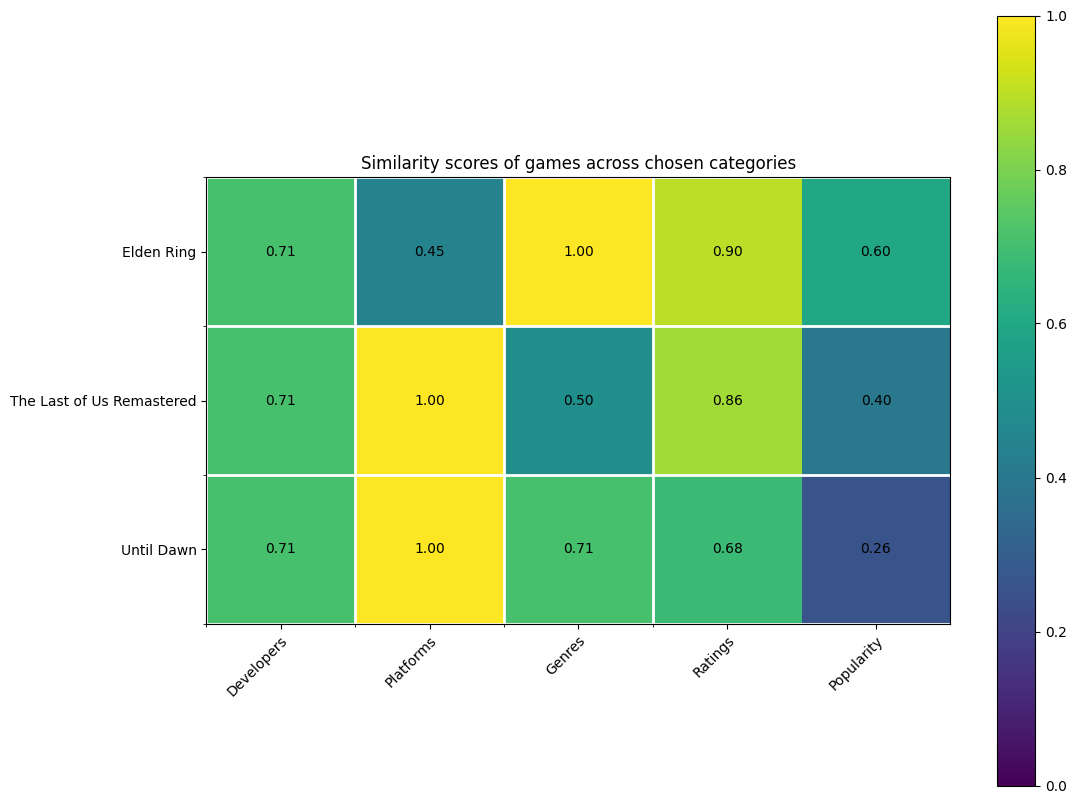

In [31]:
# Display a heat map that shows similarity scores for each game across the selected categories
game_list = []
score_list = []
for i in range(1, K+1): # First item on list will always be the selected game, so skip it
    game_list.append(game_data.loc[similarity_scores[i][0], ['Title']].item())
    score_list.append(game_data.loc[similarity_scores[i][0], ['Similarity_Scores']].item())

score_list = np.array(score_list)

fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(score_list, vmin = 0.0, vmax = 1.0)

ax.set_xticks(np.arange(len(similarity_labels)), labels=similarity_labels)
ax.set_yticks(np.arange(len(game_list)), labels=game_list)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Set up the 'spacing' of each box using white grid lines
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)
plt.grid(which='minor', color='w', linewidth='2')

# Set the text of each box
for i in range(len(game_list)):
    for j in range(len(similarity_labels)):
        text = ax.text(j, i, '{0:.2f}'.format(score_list[i,j]), ha='center', va='center', color='black')

plt.colorbar(im)
ax.set_title('Similarity scores of games across chosen categories')
plt.show()

### Final Data Pieces

I hope you enjoyed your heatmap! I think it's some pretty cool data :)

I've got three more pieces of data to visualize for you, these are in relation to the video game dataset as a whole. The first pie chart will show you the most commonly occuring genres in video games. The second will show you the most common video game developers in the world (based on our dataset). The third will show you the most popular platforms to release video games on (according to our dataset). Enjoy, and thanks for using our app!

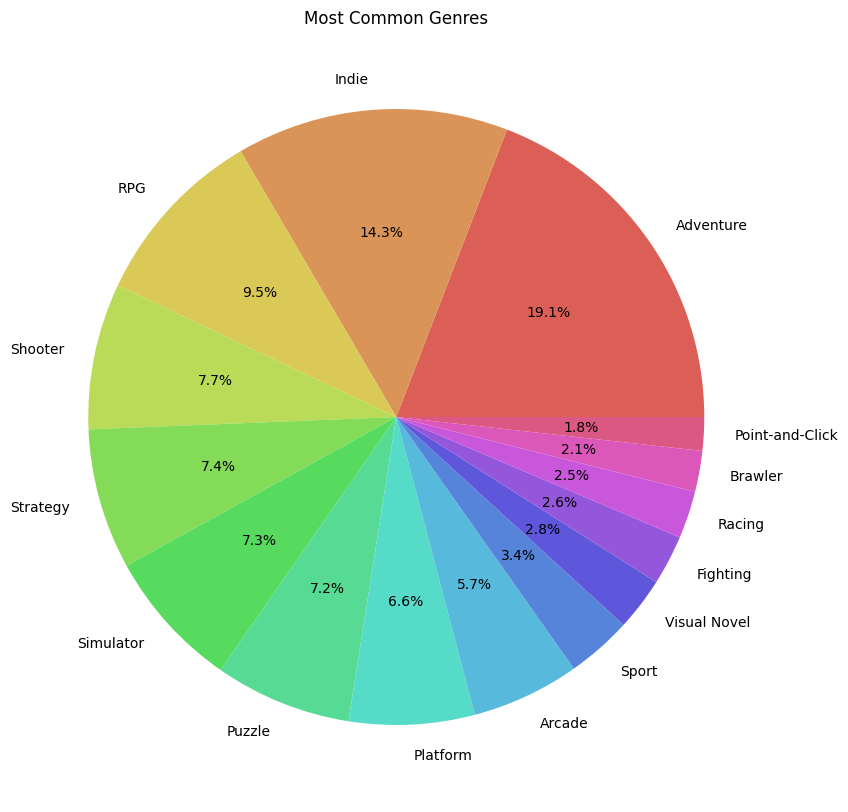

In [16]:
# Display a pie chart showing the most commonly occuring game genres
plt.subplots(figsize=(12,10))
genre_list = []
for i in game_data['Genres']:
    genre_list.extend(i)
series = pd.DataFrame(genre_list).value_counts(normalize=True)[:15].sort_values(ascending=False)
axes_tuple = series.axes[0].to_numpy()
labels = []
for axes in axes_tuple:
    labels.append(axes[0])

plt.pie(series, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('hls',15))
plt.title('Most Common Genres')
plt.show()

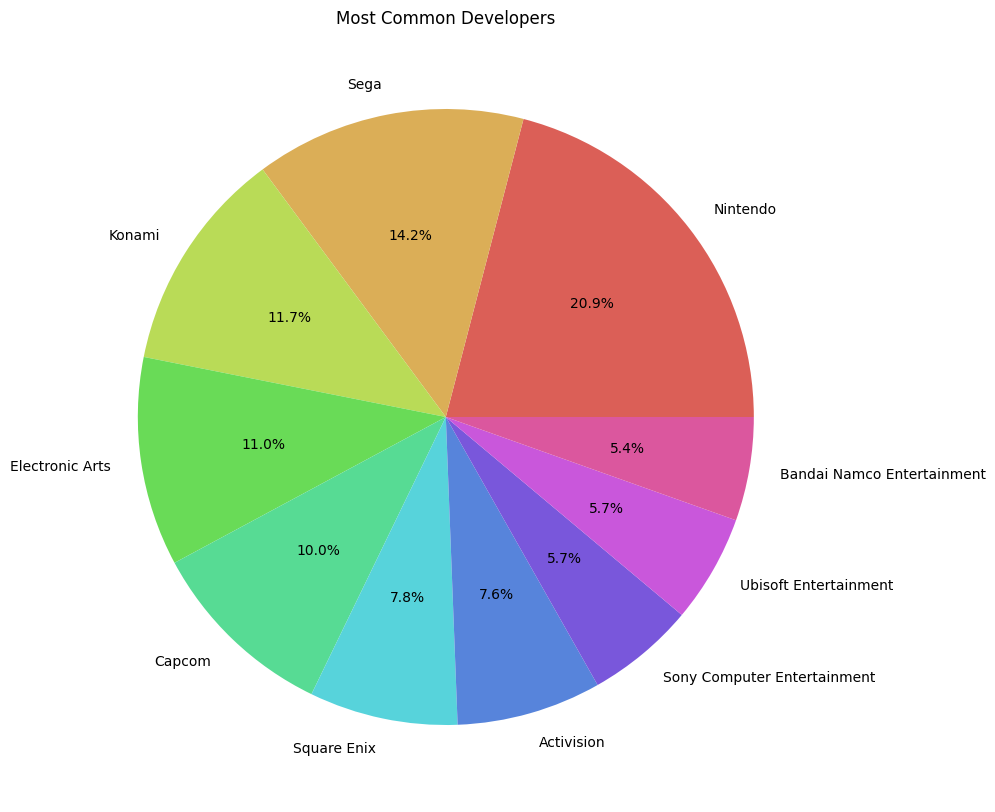

In [32]:
# Display a pie chart showing the most commonly occuring game developers
plt.subplots(figsize=(12,10))
dev_list = []
for i in game_data['Developers']:
    dev_list.extend(i)
series = pd.DataFrame(dev_list).value_counts(normalize=True)[:10].sort_values(ascending=False)
axes_tuple = series.axes[0].to_numpy()
labels = []
for axes in axes_tuple:
    labels.append(axes[0])

plt.pie(series, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('hls',10))
plt.title('Most Common Developers')
plt.show()

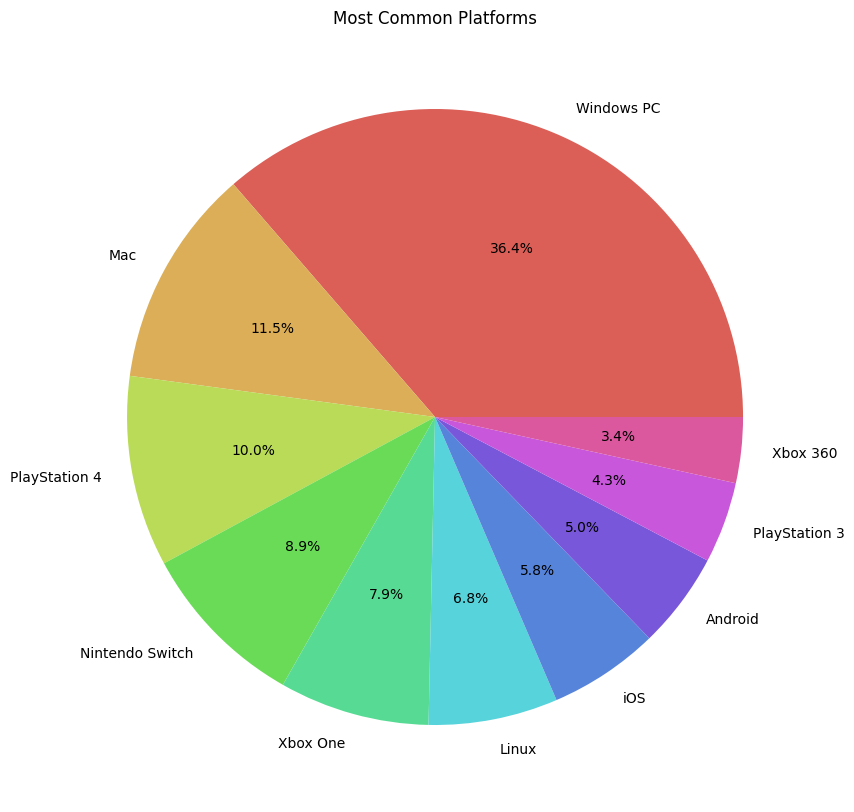

In [18]:
# Display a pie chart showing the most commonly occuring gaming platforms
plt.subplots(figsize=(12,10))
plat_list = []
for i in game_data['Platforms']:
    plat_list.extend(i)
series = pd.DataFrame(plat_list).value_counts(normalize=True)[:10].sort_values(ascending=False)
axes_tuple = series.axes[0].to_numpy()
labels = []
for axes in axes_tuple:
    labels.append(axes[0])

plt.pie(series, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('hls',10))
plt.title('Most Common Platforms')
plt.show()